In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# read ball detections of all frames
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)
ball_positions

[{1: [629.941162109375, 801.2598876953125, 646.4647216796875, 818.6962890625]},
 {1: [892.7628173828125,
   617.660888671875,
   911.4029541015625,
   637.5902709960938]},
 {},
 {},
 {},
 {},
 {1: [820.8425903320312,
   686.7548828125,
   837.8670043945312,
   705.2469482421875]},
 {1: [813.614990234375,
   694.6073608398438,
   831.87939453125,
   714.4219970703125]},
 {1: [797.6185913085938,
   718.99853515625,
   812.9331665039062,
   736.9747314453125]},
 {},
 {1: [769.191650390625,
   758.96728515625,
   788.3199462890625,
   779.3663330078125]},
 {1: [778.7589111328125,
   717.906005859375,
   795.7064208984375,
   736.1224365234375]},
 {},
 {1: [796.380615234375, 647.0301513671875, 810.76025390625, 664.04345703125]},
 {},
 {1: [814.06787109375,
   568.5234985351562,
   830.8670654296875,
   587.7296752929688]},
 {1: [819.4725341796875,
   550.931884765625,
   835.5418701171875,
   569.2645874023438]},
 {1: [827.2144775390625,
   521.1729125976562,
   844.0545043945312,
   538.72

In [ ]:
# code below with interpolate ball positions within the intermeddiate frames (if there are no ball detections)

ball_positions = [x.get(1, []) for x in ball_positions]
df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2'])

# interpret the missing values
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill() # incase the first frame doesn't have any detections, we need this to prevent the code from crashing

AttributeError: 'list' object has no attribute 'get'

In [6]:
df_ball_positions

,x1,y1,x2,y2
0,629.941162,801.259888,646.464722,818.696289
1,892.762817,617.660889,911.402954,637.590271
2,878.378772,631.479687,896.695764,651.121606
3,863.994727,645.298486,881.988574,664.652942
4,849.610681,659.117285,867.281384,678.184277
...,...,...,...,...
209,1187.354964,242.693237,1198.380672,254.653979
210,1184.491699,233.466431,1195.433716,245.321777
211,1183.037659,224.075363,1194.237122,236.625504
212,1181.583618,214.684296,1193.040527,227.929230


In [7]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2']) / 2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean() # use rolling mean to get rid of the outliers

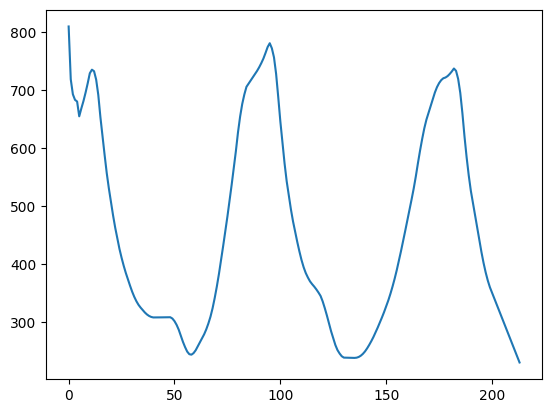

In [8]:
# plot the ball position to determine when it was hit
plt.plot(df_ball_positions['mid_y_rolling_mean'])

In [9]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()

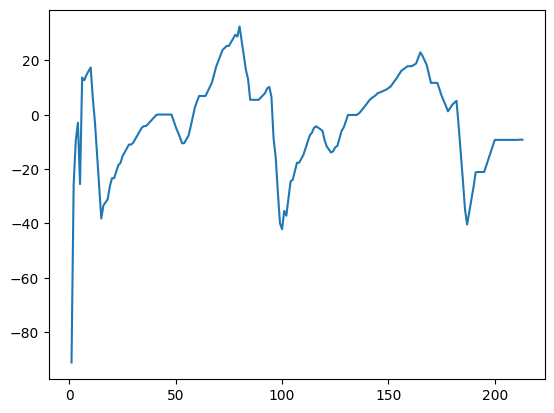

In [10]:
plt.plot(df_ball_positions['delta_y'])

## Determine the frames in which the ball was hit

In [11]:
df_ball_positions['ball_hit'] = 0
minimum_change_frames_for_hit = 25 # at least the new trend (of change in ball direction) should continue for 25 frames
for i in range(1, len(df_ball_positions) - int(minimum_change_frames_for_hit*1.2)): # buffer of 20% was added
    negative_position_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i+1] < 0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i+1] > 0

    if negative_position_change or positive_position_change:
        change_count = 0
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i+1] < 0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i+1] > 0

            if negative_position_change and negative_position_change_following_frame:
                change_count += 1
            elif positive_position_change and positive_position_change_following_frame:
                change_count += 1

        if change_count >minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1

C:\Users\Hp\AppData\Local\Temp\ipykernel_4468\1496327412.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions['ball_hit'].iloc[i] = 1
C:\Users\Hp\AppData\Local\Temp\ipykernel_4468\1496327412.py:19: SettingWithCopyWarning: 


In [12]:
df_ball_positions

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
0,629.941162,801.259888,646.464722,818.696289,809.978088,809.978088,NaN,0
1,892.762817,617.660889,911.402954,637.590271,627.625580,718.801834,-91.176254,0
2,878.378772,631.479687,896.695764,651.121606,641.300647,692.968105,-25.833729,0
3,863.994727,645.298486,881.988574,664.652942,654.975714,683.470007,-9.498098,0
4,849.610681,659.117285,867.281384,678.184277,668.650781,680.506162,-2.963845,0
...,...,...,...,...,...,...,...,...
209,1187.354964,242.693237,1198.380672,254.653979,248.673608,267.232617,-9.279504,0
210,1184.491699,233.466431,1195.433716,245.321777,239.394104,257.953113,-9.279504,0
211,1183.037659,224.075363,1194.237122,236.625504,230.350433,248.720775,-9.232338,0
212,1181.583618,214.684296,1193.040527,227.929230,221.306763,239.535604,-9.185171,0


In [13]:
df_ball_positions[df_ball_positions['ball_hit'] == 1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
5,835.226636,672.936084,852.574194,691.715613,682.325848,654.975714,-25.530448,1
11,778.758911,717.906006,795.706421,736.122437,727.014221,735.451813,6.202661,1
41,926.238914,302.722121,935.931352,313.555190,308.138655,308.031822,-0.009711,1
48,942.420044,303.192169,952.003418,313.832977,308.512573,308.405740,0.053417,1
58,926.605820,245.443771,937.560013,257.282898,251.363335,243.794219,-0.884357,1
95,616.779663,773.552734,638.745972,799.844116,786.698425,781.098022,6.577808,1
135,751.256653,232.927643,760.443359,243.129822,238.028732,238.233373,-0.102320,1
182,1298.096436,742.310120,1311.376221,756.494934,749.402527,737.485931,5.106799,1
